# Kaggle設置

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# read env var
!pip install python-dotenv
import dotenv
import os

dotenv.load_dotenv("/content/drive/MyDrive/中興_人工智慧概論/HW_final/.env")
api_token = {"username":os.getenv("KAGGLE_USERNAME"),"key":os.getenv("KAGGLE_KEY")}

!pip install kaggle

import json

kaggle_path = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_path, exist_ok=True)

with open(os.path.join(kaggle_path, "kaggle.json"), "w") as f:
    json.dump(api_token, f)

os.chmod(os.path.join(kaggle_path, "kaggle.json"), 0o600)

In [ ]:
api_token["username"]

# 觀察模型

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Trainable params:", np.sum([np.prod(v.shape) for v in base_model.trainable_weights]))

#base_model.trainable = False
for i, layer in enumerate(base_model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


NameError: name 'np' is not defined

# 定義訓練流程之通用函數

## 載入套件

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.callbacks import ModelCheckpoint

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# use the model you want
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

## 定義Dataloader

In [ ]:
def get_dataloader(train_dir, preprocess_input=None, img_size=(224, 224), batch_size=32):

  # 定義dataloader，使用資料增強（Data Augmentation）
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,  # 隨機錯切
      zoom_range=0.2,   # 隨機縮放
      horizontal_flip=True,  # 水平翻轉
      rotation_range=20,  # 隨機旋轉
      fill_mode='nearest',  # 填補模式
      validation_split=0.2
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical', # categorical
      subset='training'
  )

  val_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, val_generator


## 定義與編譯模型架構

| 模型             | 特徵圖輸出形狀 (before GAP) | GAP後形狀 (Dense輸入) |
| -------------- | -------------------- | ---------------- |
| VGG19          | (7, 7, 512)          | (512,)           |
| ResNet50       | (7, 7, 2048)         | (2048,)          |
| EfficientNetB0 | (7, 7, 1280)         | (1280,)          |


In [ ]:

def build_model_with_head(base_model, num_classes):
    """
    接收一個 base_model 並接上分類頭，回傳已編譯的模型。

    參數：
        base_model: 已經定義好輸入的預訓練模型（如 VGG19、ResNet50、EfficientNet）
        num_classes: 分類數（1 代表二分類，多類分類請傳整數 >1）
        activation: 最後一層的 activation 函數，二分類用 'sigmoid'，多類用 'softmax'
        loss: 損失函數名稱 (sparse_categorical_crossentropy)

    回傳：
        尚未編譯的 keras.Model（需由使用者自行 compile）
    """

    if num_classes < 1:
      raise ValueError("num_classes 必須 >= 1")

    #activation = 'sigmoid' if num_classes == 1 else 'softmax'
    activation = 'softmax'

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output_tensor = layers.Dense(num_classes, activation=activation)(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output_tensor)

    return model

## callback tools

In [ ]:
import pickle
import os

class HistorySaver(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
'''
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)
'''

"\nlr_scheduler = ReduceLROnPlateau(\n    monitor='val_loss',\n    factor=0.5,\n    patience=2,\n    min_lr=1e-7,\n    verbose=1\n)\n"

## 定義訓練函數

In [ ]:
def train_model_with_gpu_check(model, train_generator, val_generator, lr, epochs, save_dir, phase, lr_scheduler=None):
    """
    檢查 GPU 可用性並訓練模型，儲存最佳模型。

    參數：
        model: 已經編譯好的模型。
        train_generator: 訓練數據生成器（如 ImageDataGenerator 生成器）。
        val_generator: 驗證數據生成器（如 ImageDataGenerator 生成器）。
        epochs: 訓練的輪數（預設為 5）。
        save_dir: 儲存模型的資料夾（預設為 'models'）。
        phase: 訓練階段（'phase1' 或 'phase2'）

    回傳：
        history: 訓練過程的歷史紀錄。
    """

    # 檢查是否有可用的 GPU
    gpus = tf.config.list_physical_devices('GPU')
    #if len(gpus) == 0:
        #raise Exception("No GPU available, stop traing process")
    print("Num GPUs Available: ", len(gpus))

    #loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

    # 設定儲存中間資訊
    checkpoint = ModelCheckpoint(os.path.join(save_dir, phase + '_best_model.keras'), monitor='val_loss', save_best_only=True)
    history_saver = HistorySaver(os.path.join(save_dir, phase + '_history.pkl'))

    # 預設 learning rate scheduler
    callbacks = [checkpoint, history_saver]
    if lr_scheduler is not None:
        callbacks.append(lr_scheduler)

    # 訓練模型
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

## 視覺化呈現

In [ ]:
def plot_learning_curve_with_split(history, save_dir, phase):
    """
    根據 keras 的 history 物件繪製並儲存學習曲線。
    儲存三張圖：合併版、acc 單獨圖、loss 單獨圖。

    參數：
        history: keras.callbacks.History（model.fit() 的回傳結果）
        save_dir: 儲存圖像的資料夾（預設為 'output'）
    """
    os.makedirs(save_dir, exist_ok=True)

    # 1. 合併版
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, phase + '_learning_curve.png'))
    plt.show()

    # 2. Accuracy 單獨
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))
    plt.savefig(os.path.join(save_dir, phase + '_accuracy_curve.png'))
    #plt.show()

    # 3. Loss 單獨
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))
    plt.savefig(os.path.join(save_dir, phase + '_loss_curve.png'))
    #plt.show()


## 保存模型

In [ ]:
import os

def save_model(model, save_dir, filename):
    """
    儲存 Keras 模型為指定格式（支援 .keras 或 .h5）

    參數：
        model: 已訓練的 Keras 模型
        filename: 儲存檔名（預設為 'model.keras'）
        save_dir: 儲存資料夾（預設為 'models'）
    """
    os.makedirs(save_dir, exist_ok=True)
    full_path = os.path.join(save_dir, filename)
    model.save(full_path)
    print(f"✅ 模型已儲存至 {full_path}")


#FER plus

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download subhaditya/fer2013plus
!unzip /content/fer2013plus.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: fer2013plus/fer2013/train/sadness/fer0017536.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017542.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017574.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017577.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017579.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017584.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017610.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017616.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017623.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017633.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017649.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017669.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017671.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017676.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017679.png  
  inflating: fer201

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

'''
# 把灰階轉成 RGB 並使用 keras 的 preprocess_input
def custom_preprocessing(img):
    # 將 numpy 陣列轉為 Tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # 若是灰階（只有1個通道），轉成 RGB
    if img_tensor.shape[-1] == 1:
        img_tensor = tf.image.grayscale_to_rgb(img_tensor)

    # 再轉回 numpy 並套用 Keras 的預處理（如：ResNet50 的預處理）
    img_rgb = img_tensor.numpy()
    img_rgb = preprocess_input(img_rgb)

    return img_rgb
'''

def get_FERplus_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=validation_split
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

def get_FERplus_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 8
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FERplus"

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1
Epoch 1/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 379s 518ms/step - accuracy: 0.4444 - loss: 1.5415 - val_accuracy: 0.6154 - val_loss: 1.1202
Epoch 2/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 333s 469ms/step - accuracy: 0.6160 - loss: 1.1192 - val_accuracy: 0.6512 - val_loss: 1.0105
Epoch 3/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 332s 468ms/step - accuracy: 0.6522 - loss: 1.0116 - val_accuracy: 0.6761 - val_loss: 0.9291
Epoch 4/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 333s 469ms/step - accuracy: 0.6750 - loss: 0.9553 - val_accuracy: 0.6829 - val_loss: 0.9096
Epoch 5/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 332s 468ms/step - accuracy: 0.6929 - loss: 0.8947 - val_accuracy: 0.6914 - val_loss: 0.8849


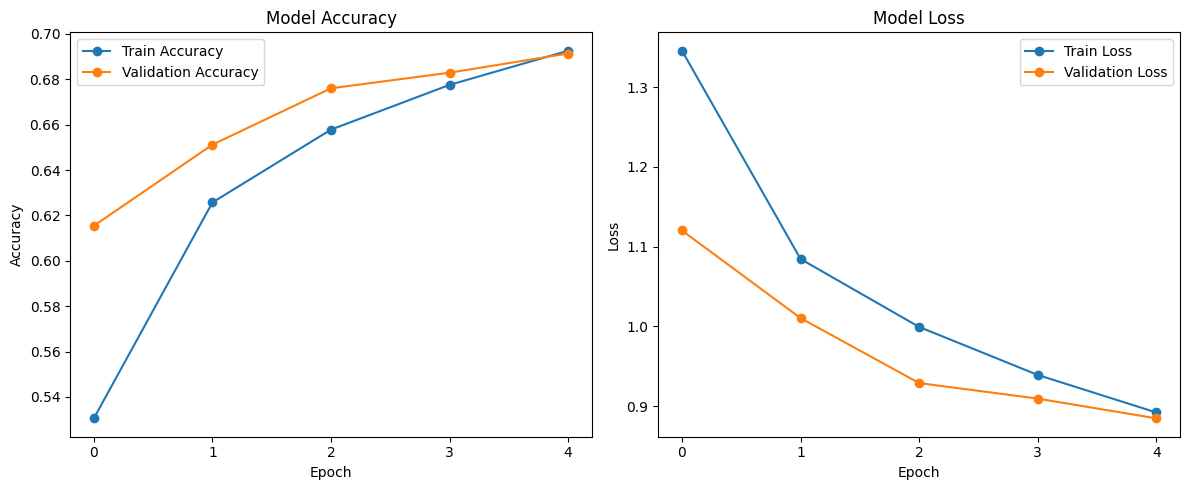

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FERplus/ResNet50_FERplus_phase1.keras


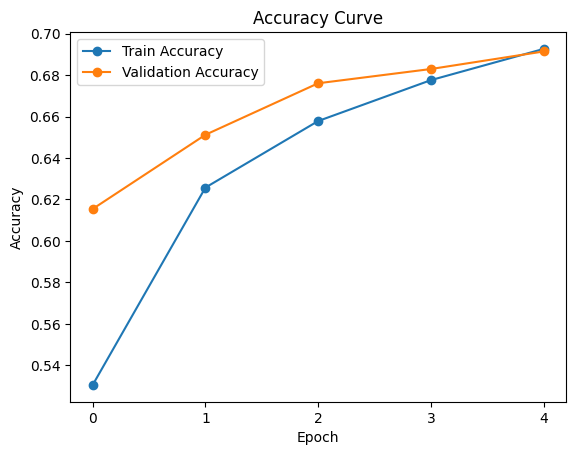

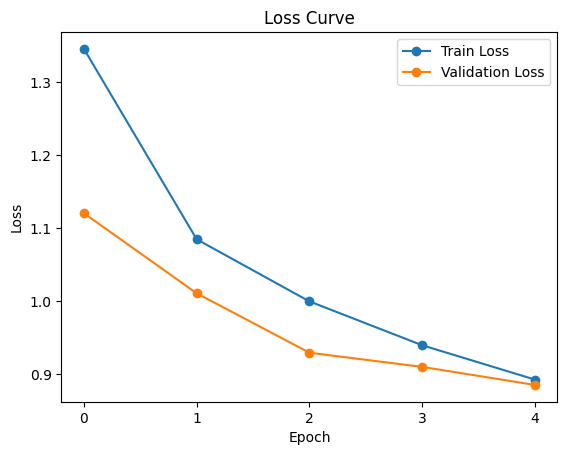

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True  # 凍結卷積層
for layer in base_model.layers[:165]: # 165: start of cov5 block3
    layer.trainable = False
for layer in base_model.layers[165:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_FERplus_" + phase + ".keras")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1
Epoch 1/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 377s 502ms/step - accuracy: 0.7113 - loss: 0.8144 - val_accuracy: 0.7237 - val_loss: 0.8000 - learning_rate: 1.0000e-05
Epoch 2/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 341s 479ms/step - accuracy: 0.7322 - loss: 0.7685 - val_accuracy: 0.7249 - val_loss: 0.7778 - learning_rate: 1.0000e-05
Epoch 3/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 343s 483ms/step - accuracy: 0.7351 - loss: 0.7517 - val_accuracy: 0.7319 - val_loss: 0.7574 - learning_rate: 1.0000e-05
Epoch 4/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 340s 479ms/step - accuracy: 0.7515 - loss: 0.7131 - val_accuracy: 0.7422 - val_loss: 0.7369 - learning_rate: 1.0000e-05
Epoch 5/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 339s 477ms/step - accuracy: 0.7611 - loss: 0.6944 - val_accuracy: 0.7446 - val_loss: 0.7265 - learning_rate: 1.0000e-05
Epoch 6/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 379s 473ms/step - accuracy: 0.7720 - loss: 0.6616 - 

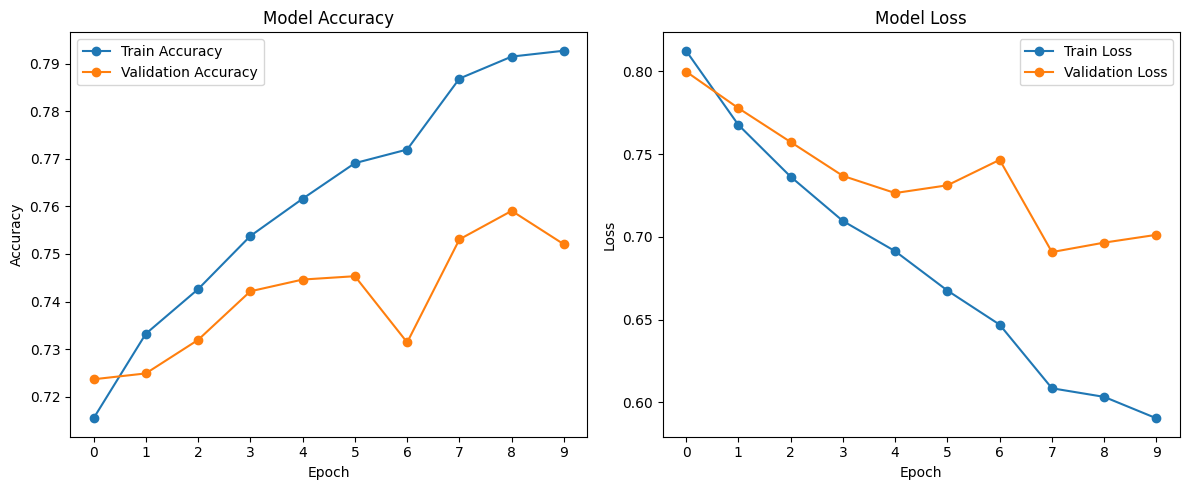

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FERplus/ResNet50_FERplus_phase2.keras


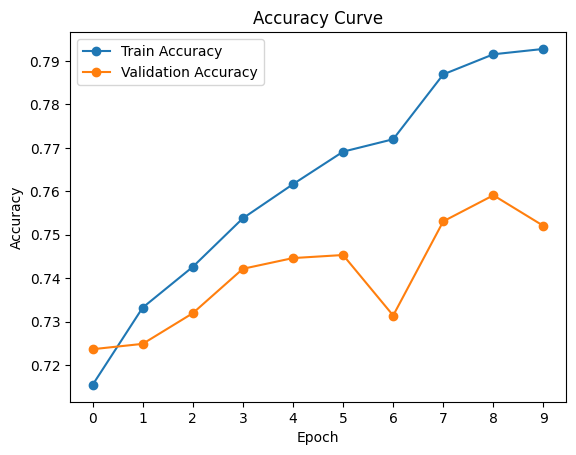

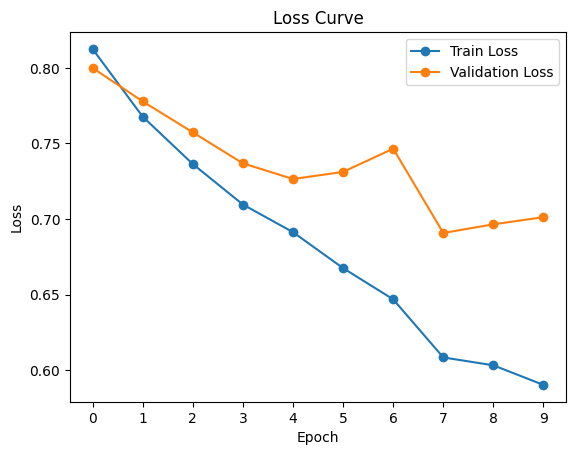

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_FERplus_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:143]: # 143: start of cov5 block1
    layer.trainable = False
for layer in model.layers[143:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_FERplus_" + phase + ".keras")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1
Epoch 1/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 397s 527ms/step - accuracy: 0.7925 - loss: 0.5938 - val_accuracy: 0.7577 - val_loss: 0.6750 - learning_rate: 5.0000e-06
Epoch 2/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 358s 504ms/step - accuracy: 0.8049 - loss: 0.5557 - val_accuracy: 0.7697 - val_loss: 0.6512 - learning_rate: 5.0000e-06
Epoch 3/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 354s 499ms/step - accuracy: 0.8097 - loss: 0.5413 - val_accuracy: 0.7654 - val_loss: 0.6667 - learning_rate: 5.0000e-06
Epoch 4/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8151 - loss: 0.5284
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
710/710 ━━━━━━━━━━━━━━━━━━━━ 357s 502ms/step - accuracy: 0.8151 - loss: 0.5284 - val_accuracy: 0.7728 - val_loss: 0.6605 - learning_rate: 5.0000e-06
Epoch 5/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 353s 497ms/step - accuracy: 0.8209 - loss: 0.5086 - val_acc

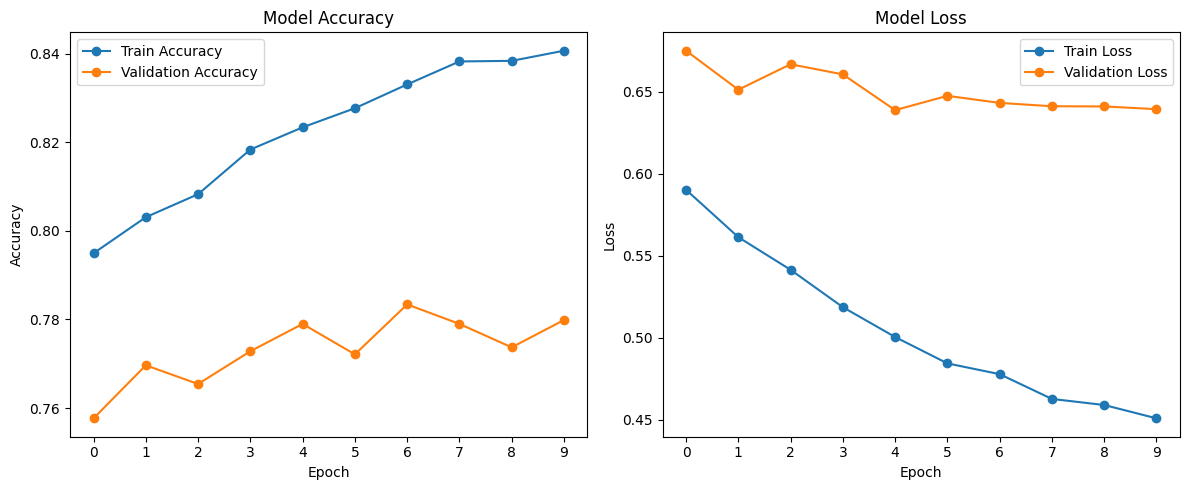

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FERplus/ResNet50_FERplus_phase3.keras


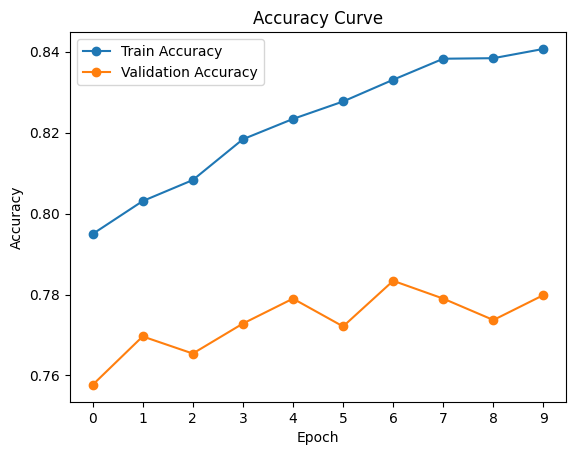

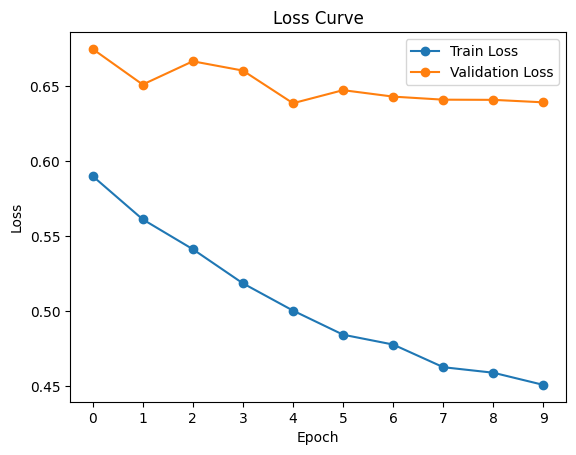

In [ ]:
# phase 3
lr = 5e-6
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_FERplus_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:81]:  #  81 | conv4_block1_1_conv
    layer.trainable = False
for layer in model.layers[81:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_FERplus_" + phase + ".keras")

# RAF-DB


    資料容易過擬合
    ➤ 高解析度 + 彩色照片 + 背景豐富 → 模型易學到非表情特徵（如背景、髮型）

    類別分布不均
    ➤ 快樂、中性樣本佔比極高，導致模型偏向多數類別 → 驗證集上泛化不佳
    
      訓練時模型過度學習多數類別，train acc 較高。
      驗證時少數類別預測失誤，拉低 val acc，造成 gap。

    訓練樣本較少
    ➤ RAF-DB 訓練集樣本比 FER+ 少 → 模型泛化能力下降，容易背誦

    驗證集難度較高
    ➤ 包含更多自然變化（角度、光線） → 驗證表現受影響

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download shuvoalok/raf-db-dataset
!unzip /content/raf-db-dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: DATASET/train/5/train_00987_aligned.jpg  
  inflating: DATASET/train/5/train_00990_aligned.jpg  
  inflating: DATASET/train/5/train_00991_aligned.jpg  
  inflating: DATASET/train/5/train_00992_aligned.jpg  
  inflating: DATASET/train/5/train_01002_aligned.jpg  
  inflating: DATASET/train/5/train_01010_aligned.jpg  
  inflating: DATASET/train/5/train_01011_aligned.jpg  
  inflating: DATASET/train/5/train_01013_aligned.jpg  
  inflating: DATASET/train/5/train_01015_aligned.jpg  
  inflating: DATASET/train/5/train_01017_aligned.jpg  
  inflating: DATASET/train/5/train_01039_aligned.jpg  
  inflating: DATASET/train/5/train_01048_aligned.jpg  
  inflating: DATASET/train/5/train_01049_aligned.jpg  
  inflating: DATASET/train/5/train_01053_aligned.jpg  
  inflating: DATASET/train/5/train_01070_aligned.jpg  
  inflating: DATASET/train/5/train_01074_aligned.jpg  
  inflating: DATASET/train/5/train_01078_aligned.jpg  
  inflating: DATASET/train/5/train_01083_ali

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_RAFDB_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    """
    用來載入訓練資料集並進行資料增強（data augmentation）。

    參數：
        train_dir (str): 訓練資料集的根目錄。
        img_size (tuple): 輸入影像大小。
        batch_size (int): 批次大小。
        validation_split (float): 用來分割訓練資料與驗證資料的比例。

    回傳：
        train_generator: 訓練資料生成器。
        val_generator: 驗證資料生成器。
    """

    # 定義資料增強
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,  # 隨機錯切
        zoom_range=0.2,   # 隨機縮放
        horizontal_flip=True,  # 水平翻轉
        rotation_range=20,  # 隨機旋轉
        fill_mode='nearest',  # 填補模式
        validation_split=validation_split  # 設定驗證集的比例
    )

    # 訓練集生成器
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  # 類別模式：多類別分類
        subset='training'  # 設定為訓練集
    )

    # 驗證集生成器
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'  # 設定為驗證集
    )

    return train_generator, val_generator


In [ ]:
def get_RAFDB_testloader(test_dir, img_size=(224, 224), batch_size=32):
    """
    用來載入測試資料集。

    參數：
        test_dir (str): 測試資料集的根目錄。
        img_size (tuple): 輸入影像大小。
        batch_size (int): 批次大小。

    回傳：
        test_generator: 測試資料生成器。
    """

    # 定義資料增強（此處測試資料集只會預處理，不進行增強）
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # 測試集生成器
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  # 類別模式：多類別分類
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 7
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/RAF-DB"

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 186s 552ms/step - accuracy: 0.3589 - loss: 1.7877 - val_accuracy: 0.5926 - val_loss: 1.1937
Epoch 2/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 148s 483ms/step - accuracy: 0.5573 - loss: 1.2416 - val_accuracy: 0.6313 - val_loss: 1.0355
Epoch 3/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 147s 478ms/step - accuracy: 0.5941 - loss: 1.1184 - val_accuracy: 0.6501 - val_loss: 0.9973
Epoch 4/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 145s 473ms/step - accuracy: 0.6424 - loss: 1.0122 - val_accuracy: 0.6762 - val_loss: 0.9245
Epoch 5/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 207s 489ms/step - accuracy: 0.6722 - loss: 0.9156 - val_accuracy: 0.6733 - val_loss: 0.9056


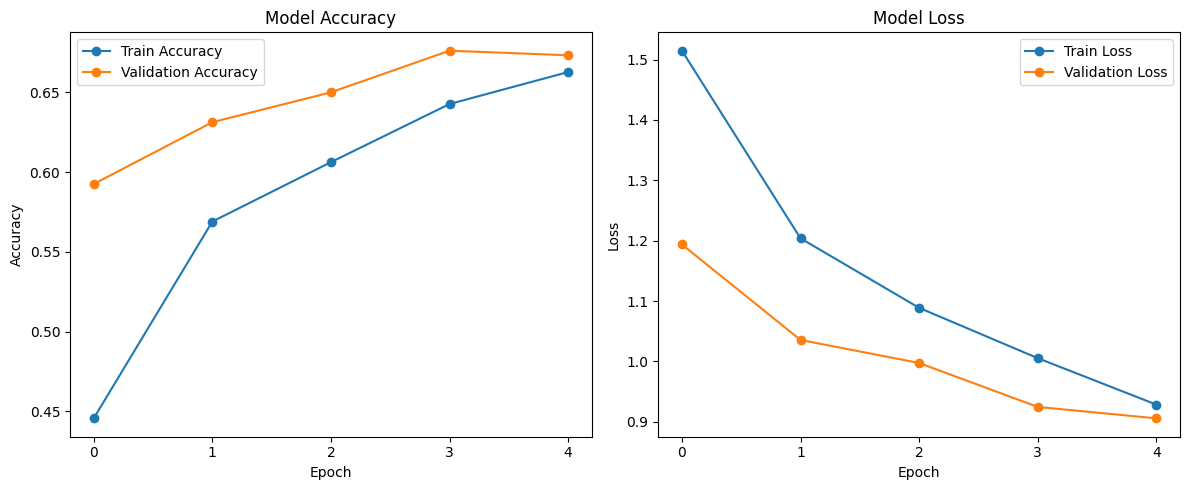

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/RAF-DB/ResNet50_RAF-DB_phase1.keras


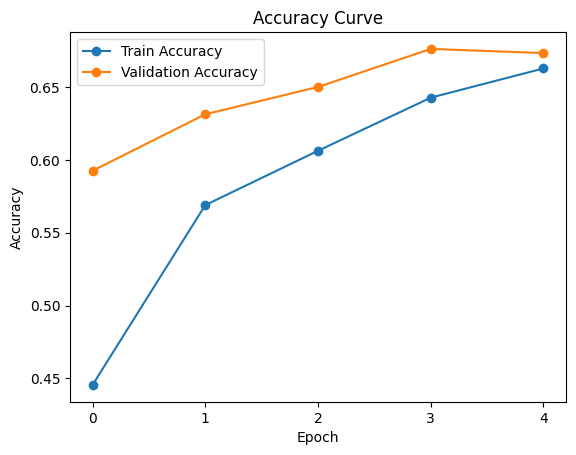

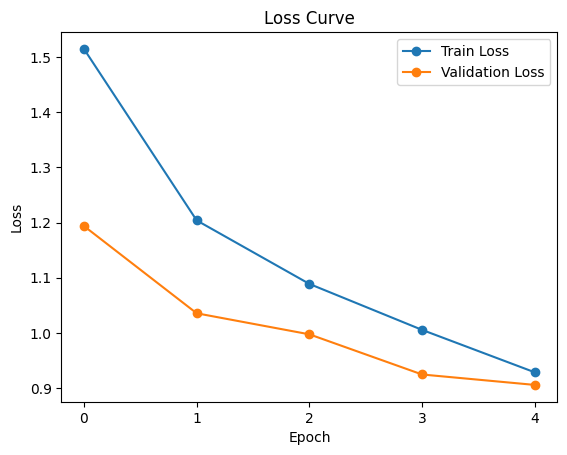

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True
for layer in base_model.layers[:165]: # 165: start of cov5 block3
    layer.trainable = False
for layer in base_model.layers[165:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_RAF-DB_" + phase + ".keras")

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1
Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 176s 526ms/step - accuracy: 0.6982 - loss: 0.8560 - val_accuracy: 0.7031 - val_loss: 0.8437
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 151s 492ms/step - accuracy: 0.7188 - loss: 0.7697 - val_accuracy: 0.7129 - val_loss: 0.8185
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 154s 502ms/step - accuracy: 0.7327 - loss: 0.7516 - val_accuracy: 0.7263 - val_loss: 0.7941
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 150s 487ms/step - accuracy: 0.7494 - loss: 0.7048 - val_accuracy: 0.7170 - val_loss: 0.8183
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 147s 480ms/step - accuracy: 0.7531 - loss: 0.6886 - val_accuracy: 0.7223 - val_loss: 0.7979
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 148s 481ms/step - accuracy: 0.7647 - loss: 0.6634 - val_accuracy: 0.7374 - val_loss: 0.7570
Epoch 7/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 152s 495ms/step - accuracy: 0.7771 - loss: 0.6266 - val_accur

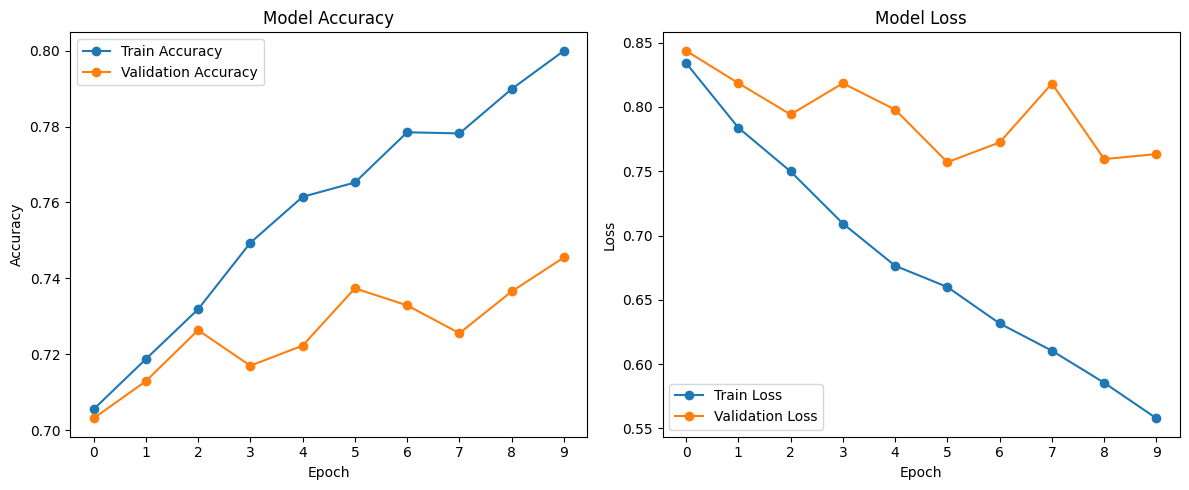

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/RAF-DB/ResNet50_RAF-DB_phase2.keras


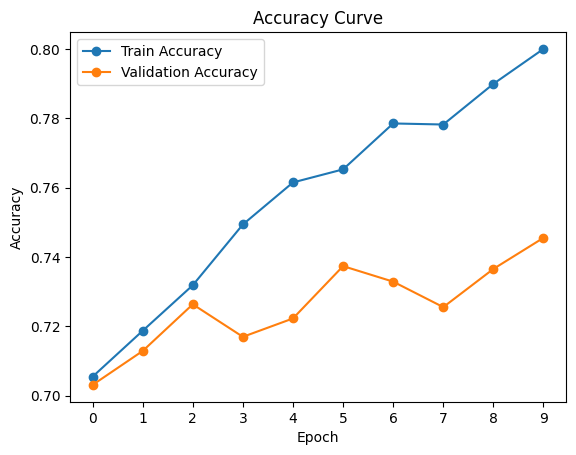

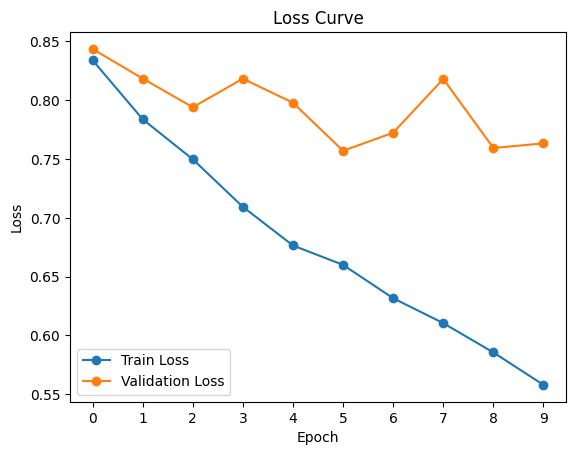

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_RAF-DB_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:143]:  # 143: start of cov5 block1
    layer.trainable = False
for layer in model.layers[143:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_RAF-DB_" + phase + ".keras")

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 203s 584ms/step - accuracy: 0.8118 - loss: 0.5472 - val_accuracy: 0.7418 - val_loss: 0.7708 - learning_rate: 1.0000e-05
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 159s 518ms/step - accuracy: 0.8186 - loss: 0.5022 - val_accuracy: 0.7512 - val_loss: 0.7313 - learning_rate: 1.0000e-05
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 159s 519ms/step - accuracy: 0.8266 - loss: 0.4911 - val_accuracy: 0.7663 - val_loss: 0.7549 - learning_rate: 1.0000e-05
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step - accuracy: 0.8424 - loss: 0.4429
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
307/307 ━━━━━━━━━━━━━━━━━━━━ 156s 506ms/step - accuracy: 0.8424 - loss: 0.4429 - val_accuracy: 0.7508 - val_loss: 0.7515 - learning_rate: 1.0000e-05
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 154s 501ms/step - accuracy: 0.8623 - loss: 0.3978 - val_accuracy: 0.7618 - val_loss: 0.7603 - learning_rate: 5.0000e-06
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 0s 407m

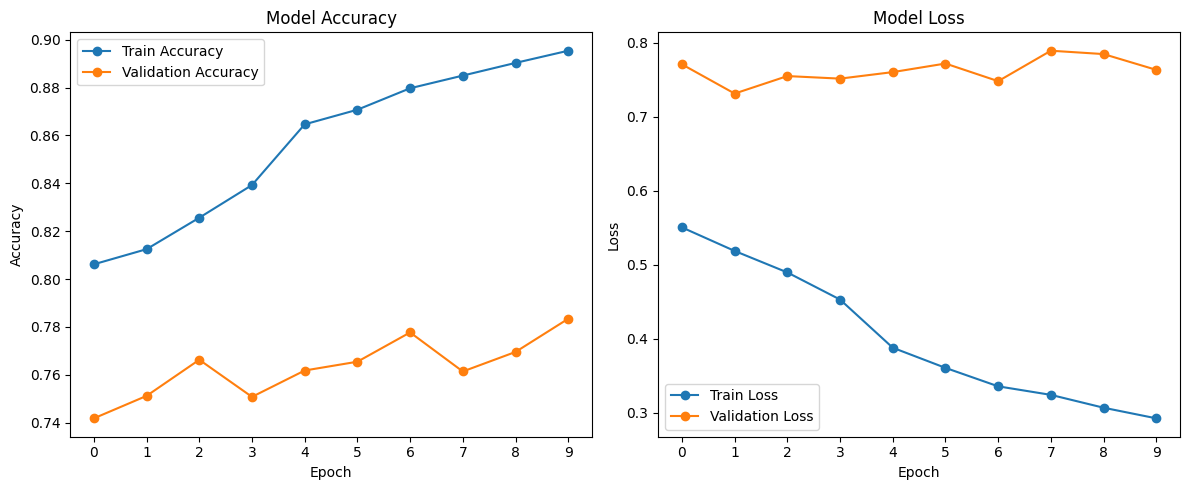

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/RAF-DB/ResNet50_RAF-DB_phase3.keras


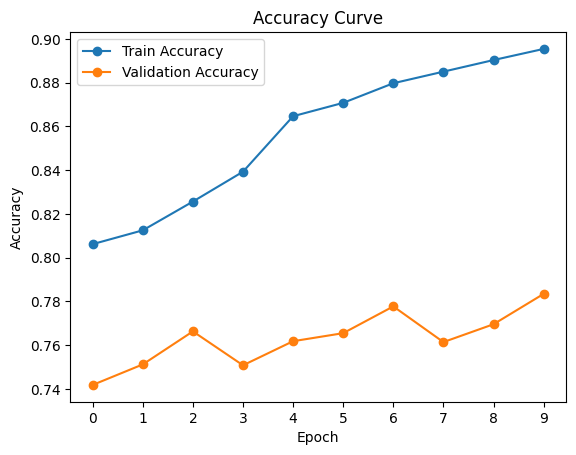

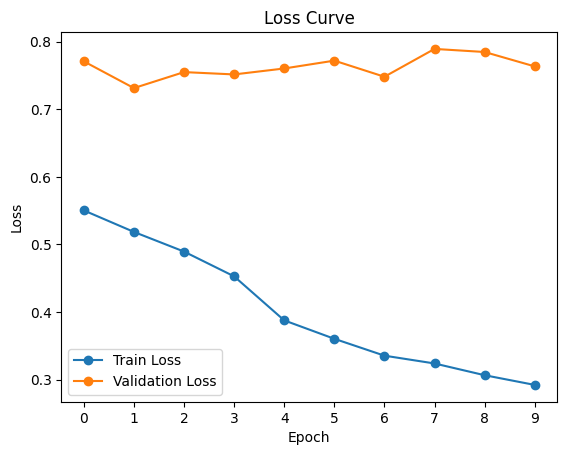

In [ ]:
# phase 3
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_RAF-DB_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:81]:  #  81 | conv4_block1_1_conv
    layer.trainable = False
for layer in model.layers[81:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_RAF-DB_" + phase + ".keras")

#AffectNet subset

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download yakhyokhuja/affectnetaligned
!unzip /content/affectnetaligned.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: AffectNetCustom/train/6/image0016315.jpg  
  inflating: AffectNetCustom/train/6/image0016316.jpg  
  inflating: AffectNetCustom/train/6/image0016318.jpg  
  inflating: AffectNetCustom/train/6/image0016319.jpg  
  inflating: AffectNetCustom/train/6/image0016324.jpg  
  inflating: AffectNetCustom/train/6/image0016332.jpg  
  inflating: AffectNetCustom/train/6/image0016333.jpg  
  inflating: AffectNetCustom/train/6/image0016336.jpg  
  inflating: AffectNetCustom/train/6/image0016340.jpg  
  inflating: AffectNetCustom/train/6/image0016343.jpg  
  inflating: AffectNetCustom/train/6/image0016344.jpg  
  inflating: AffectNetCustom/train/6/image0016347.jpg  
  inflating: AffectNetCustom/train/6/image0016354.jpg  
  inflating: AffectNetCustom/train/6/image0016358.jpg  
  inflating: AffectNetCustom/train/6/image0016363.jpg  
  inflating: AffectNetCustom/train/6/image0016364.jpg  
  inflating: AffectNetCustom/train/6/image0016367.jpg  
  inflating: AffectNetCusto

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

def get_AffectNet_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=validation_split
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

def get_AffectNet_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 8
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/AffectNet"

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Found 30030 images belonging to 8 classes.
Found 7503 images belonging to 8 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 549s 564ms/step - accuracy: 0.2308 - loss: 2.0122 - val_accuracy: 0.4026 - val_loss: 1.5823
Epoch 2/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 470s 500ms/step - accuracy: 0.3915 - loss: 1.6063 - val_accuracy: 0.4289 - val_loss: 1.5014
Epoch 3/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 466s 497ms/step - accuracy: 0.4396 - loss: 1.4980 - val_accuracy: 0.4496 - val_loss: 1.4439
Epoch 4/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 484s 516ms/step - accuracy: 0.4698 - loss: 1.4251 - val_accuracy: 0.4682 - val_loss: 1.4036
Epoch 5/5
939/939 ━━━━━━━━━━━━━━━━━━━━ 482s 513ms/step - accuracy: 0.4866 - loss: 1.3730 - val_accuracy: 0.4818 - val_loss: 1.3747


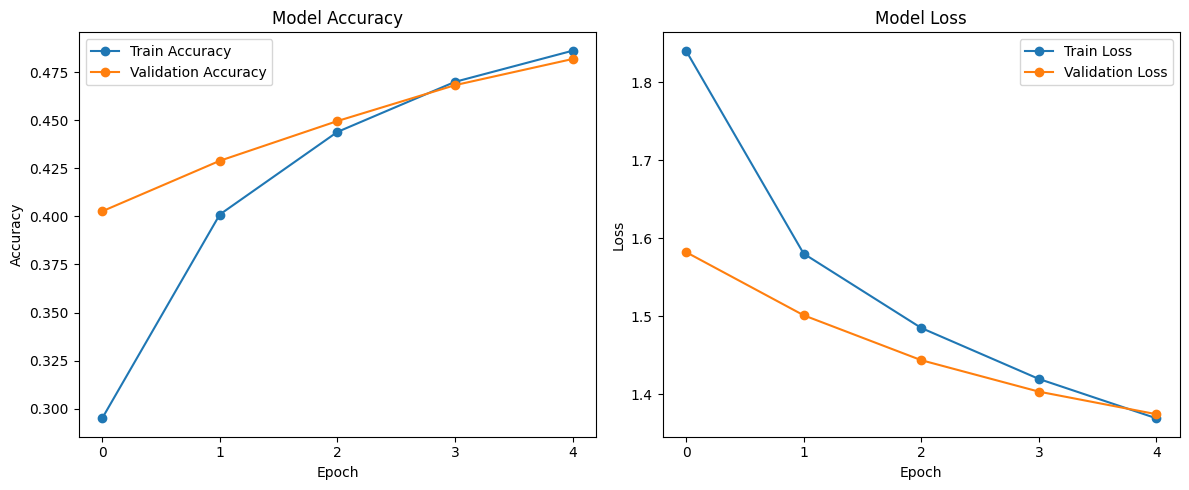

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/AffectNet/ResNet50_AffectNet_phase1.keras


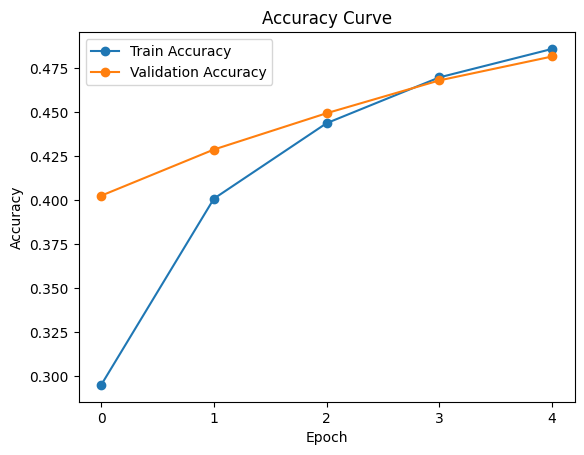

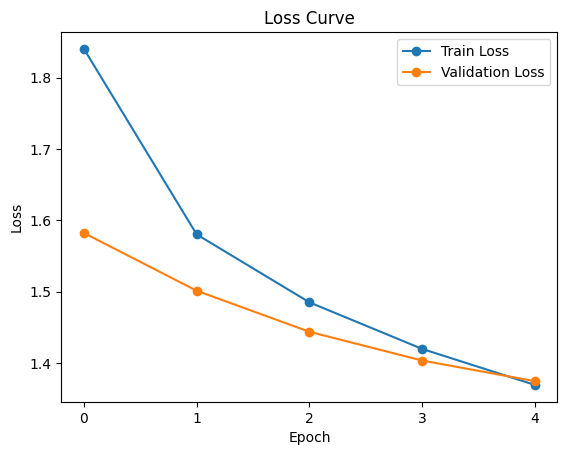

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True  # 凍結卷積層
for layer in base_model.layers[:165]: # 165: start of cov5 block3
    layer.trainable = False
for layer in base_model.layers[165:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_AffectNet_trainloader('/content/AffectNetCustom/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_AffectNet_" + phase + ".keras")

Found 30030 images belonging to 8 classes.
Found 7503 images belonging to 8 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 516s 530ms/step - accuracy: 0.4838 - loss: 1.3751 - val_accuracy: 0.4998 - val_loss: 1.3285 - learning_rate: 5.0000e-05
Epoch 2/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 485s 517ms/step - accuracy: 0.5232 - loss: 1.2860 - val_accuracy: 0.5109 - val_loss: 1.2988 - learning_rate: 5.0000e-05
Epoch 3/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 483s 514ms/step - accuracy: 0.5358 - loss: 1.2399 - val_accuracy: 0.4989 - val_loss: 1.3162 - learning_rate: 5.0000e-05
Epoch 4/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 479s 510ms/step - accuracy: 0.5624 - loss: 1.1875 - val_accuracy: 0.5194 - val_loss: 1.2873 - learning_rate: 5.0000e-05
Epoch 5/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 476s 507ms/step - accuracy: 0.5715 - loss: 1.1571 - val_accuracy: 0.5301 - val_loss: 1.2495 - learning_rate: 5.0000e-05
Epoch 6/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 494s 499ms/step - accuracy: 0.5906 - loss: 1.1063 - val_accuracy: 0.5230 - val_loss: 1.3122 - learning_rate: 5.0000e-05
Epoch 7/10
939/939 ━━━━━━━━━━━━━━━━━━━━ 

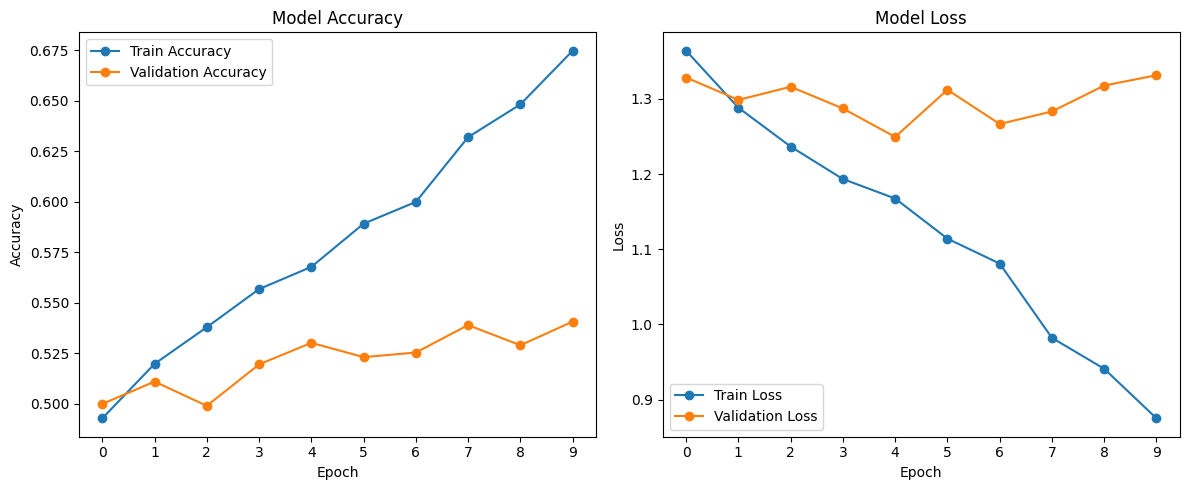

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/AffectNet/ResNet50_AffectNet_phase2.keras


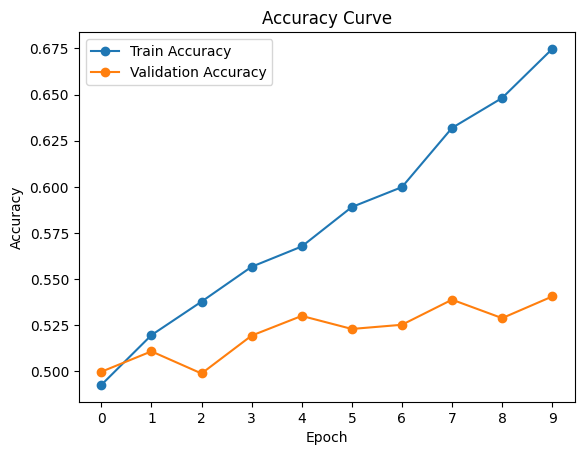

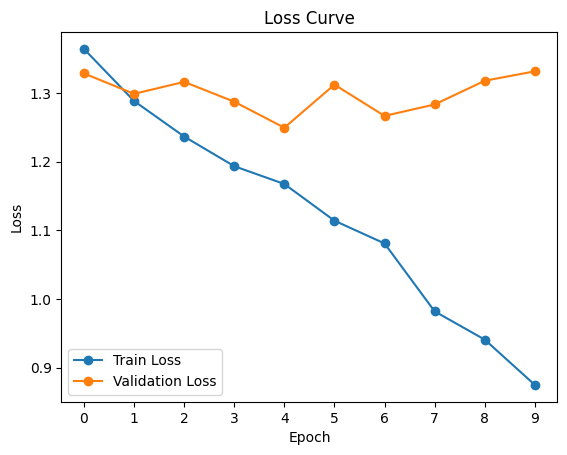

In [ ]:
# phase 2
lr = 5e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_AffectNet_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:143]: # 143: start of cov5 block1
    layer.trainable = False
for layer in model.layers[143:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_AffectNet_trainloader('/content/AffectNetCustom/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_AffectNet_" + phase + ".keras")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1
Epoch 1/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 397s 527ms/step - accuracy: 0.7925 - loss: 0.5938 - val_accuracy: 0.7577 - val_loss: 0.6750 - learning_rate: 5.0000e-06
Epoch 2/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 358s 504ms/step - accuracy: 0.8049 - loss: 0.5557 - val_accuracy: 0.7697 - val_loss: 0.6512 - learning_rate: 5.0000e-06
Epoch 3/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 354s 499ms/step - accuracy: 0.8097 - loss: 0.5413 - val_accuracy: 0.7654 - val_loss: 0.6667 - learning_rate: 5.0000e-06
Epoch 4/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.8151 - loss: 0.5284
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
710/710 ━━━━━━━━━━━━━━━━━━━━ 357s 502ms/step - accuracy: 0.8151 - loss: 0.5284 - val_accuracy: 0.7728 - val_loss: 0.6605 - learning_rate: 5.0000e-06
Epoch 5/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 353s 497ms/step - accuracy: 0.8209 - loss: 0.5086 - val_acc

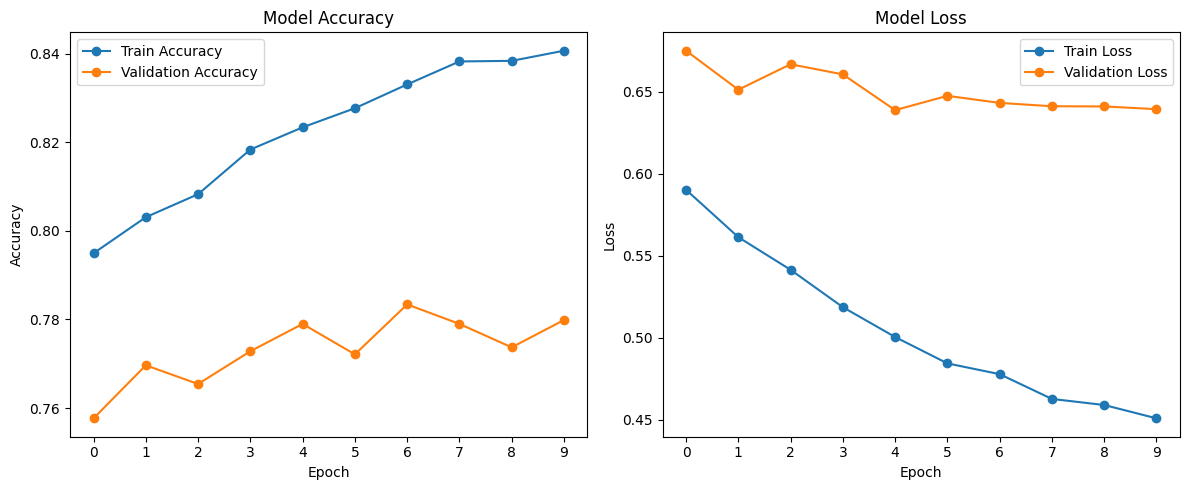

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FERplus/ResNet50_FERplus_phase3.keras


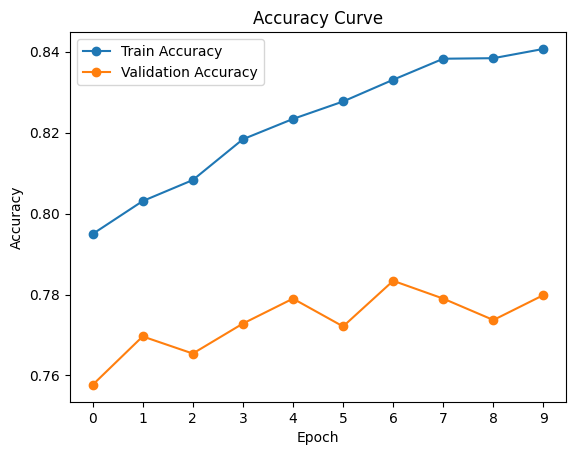

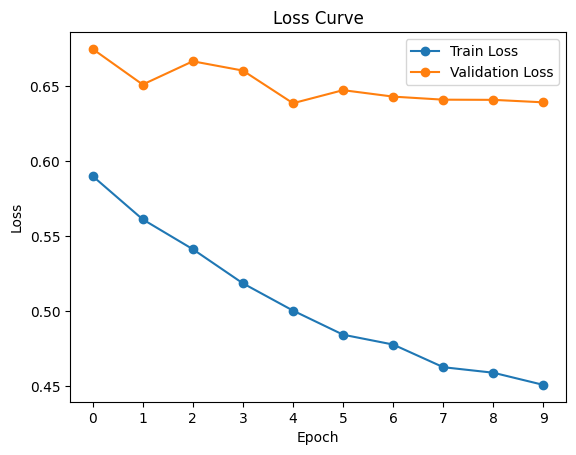

In [ ]:
# phase 3
lr = 5e-6
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_AffectNet_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:81]:  #  81 | conv4_block1_1_conv
    layer.trainable = False
for layer in model.layers[81:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_AffectNet_trainloader('/content/AffectNetCustom/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_AffectNet_" + phase + ".keras")

#FER 2013

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download msambare/fer2013
!unzip /content/fer2013.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating: train/sad/Training_65526454.

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

'''
# 把灰階轉成 RGB 並使用 keras 的 preprocess_input
def custom_preprocessing(img):
    # 將 numpy 陣列轉為 Tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # 若是灰階（只有1個通道），轉成 RGB
    if img_tensor.shape[-1] == 1:
        img_tensor = tf.image.grayscale_to_rgb(img_tensor)

    # 再轉回 numpy 並套用 Keras 的預處理（如：ResNet50 的預處理）
    img_rgb = img_tensor.numpy()
    img_rgb = preprocess_input(img_rgb)

    return img_rgb
'''

def get_FER2013_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=validation_split
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

def get_FER2013_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 7
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FER2013"

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 408s 543ms/step - accuracy: 0.2838 - loss: 1.8327 - val_accuracy: 0.4513 - val_loss: 1.4382
Epoch 2/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 372s 517ms/step - accuracy: 0.4328 - loss: 1.4633 - val_accuracy: 0.4799 - val_loss: 1.3546
Epoch 3/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 381s 517ms/step - accuracy: 0.4873 - loss: 1.3474 - val_accuracy: 0.4952 - val_loss: 1.3146
Epoch 4/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 375s 522ms/step - accuracy: 0.5065 - loss: 1.3002 - val_accuracy: 0.5175 - val_loss: 1.2829
Epoch 5/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 371s 517ms/step - accuracy: 0.5191 - loss: 1.2695 - val_accuracy: 0.5217 - val_loss: 1.2442


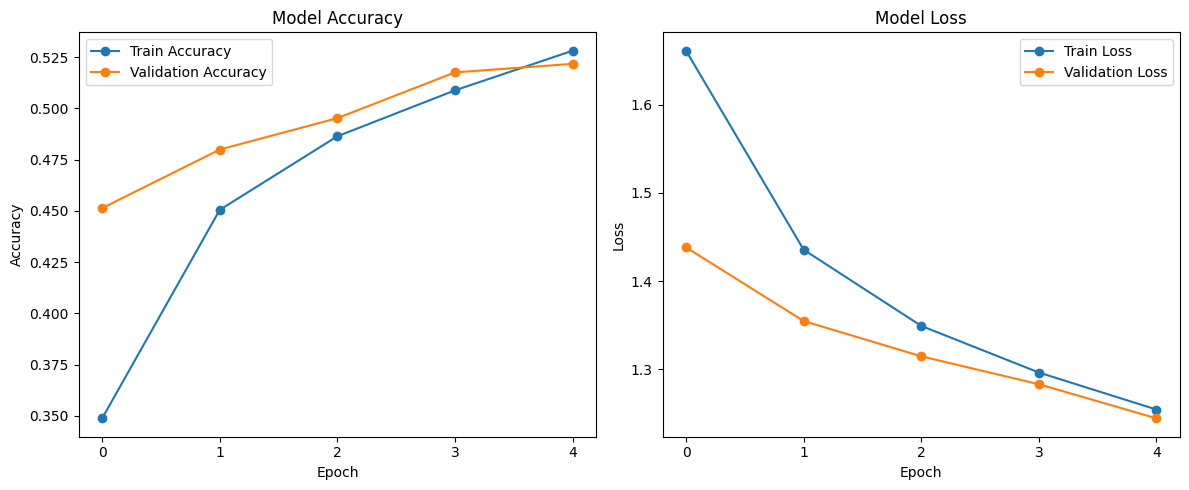

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FER2013/ResNet50_FER2013_phase1.keras


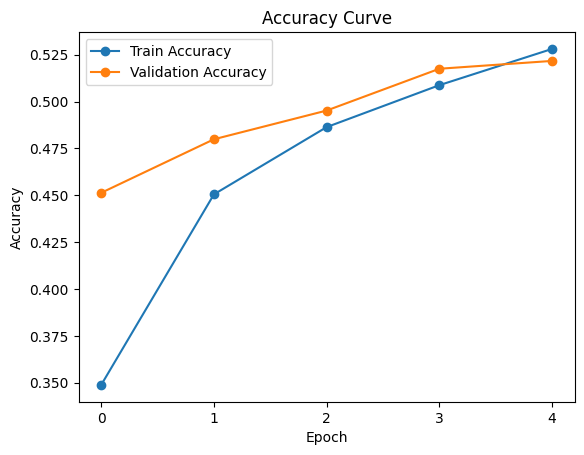

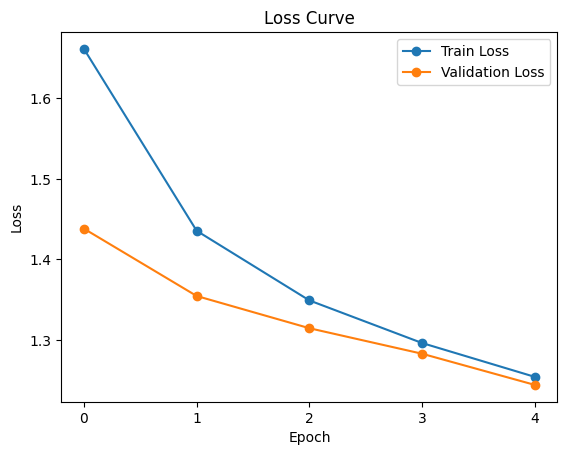

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True  # 凍結卷積層
for layer in base_model.layers[:165]: # 165: start of cov5 block3
    layer.trainable = False
for layer in base_model.layers[165:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_FER2013_" + phase + ".keras")

In [ ]:
# prompt: sleep 10

import time
time.sleep(10)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1
Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 413s 549ms/step - accuracy: 0.5435 - loss: 1.1972 - val_accuracy: 0.5485 - val_loss: 1.1883 - learning_rate: 1.0000e-05
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 379s 528ms/step - accuracy: 0.5710 - loss: 1.1440 - val_accuracy: 0.5560 - val_loss: 1.1801 - learning_rate: 1.0000e-05
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 384s 534ms/step - accuracy: 0.5720 - loss: 1.1357 - val_accuracy: 0.5694 - val_loss: 1.1548 - learning_rate: 1.0000e-05
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 440s 532ms/step - accuracy: 0.5895 - loss: 1.0857 - val_accuracy: 0.5715 - val_loss: 1.1280 - learning_rate: 1.0000e-05
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 440s 530ms/step - accuracy: 0.5932 - loss: 1.0758 - val_accuracy: 0.5665 - val_loss: 1.1479 - learning_rate: 1.0000e-05
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 379s 528ms/step - accuracy: 0.5966 - loss: 1.0619 - 

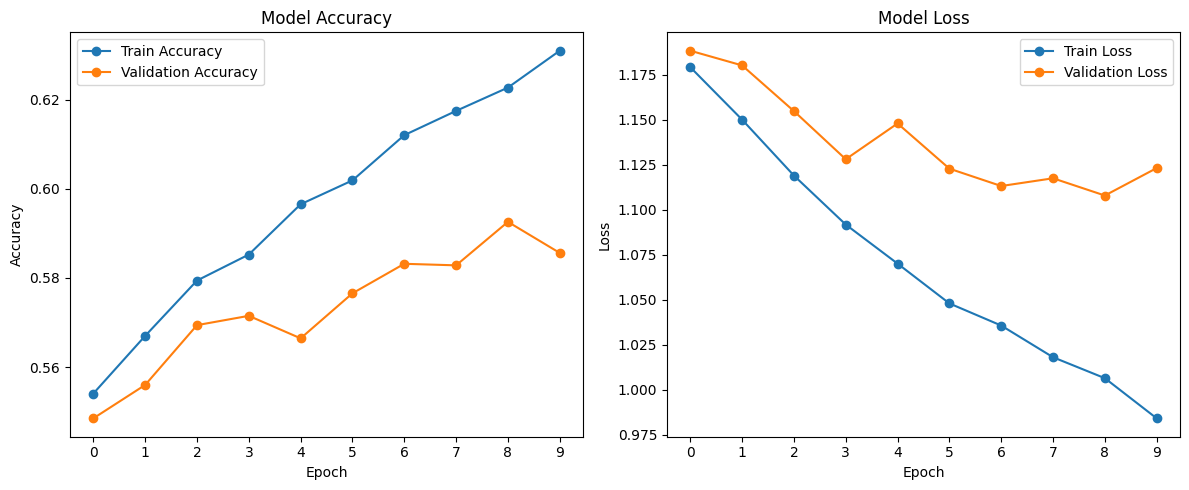

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FER2013/ResNet50_FER2013_phase2.keras


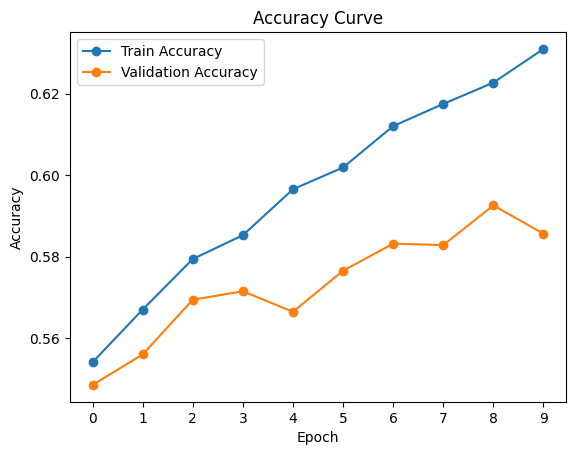

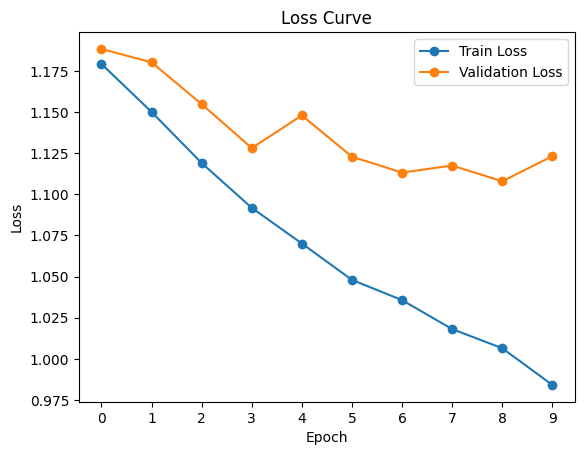

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_FER2013_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:143]: # 143: start of cov5 block1
    layer.trainable = False
for layer in model.layers[143:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_FER2013_" + phase + ".keras")

In [ ]:
# prompt: sleep 10

import time
time.sleep(10)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1
Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 437s 575ms/step - accuracy: 0.6423 - loss: 0.9553 - val_accuracy: 0.5945 - val_loss: 1.0836 - learning_rate: 5.0000e-06
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 401s 558ms/step - accuracy: 0.6475 - loss: 0.9301 - val_accuracy: 0.6046 - val_loss: 1.0731 - learning_rate: 5.0000e-06
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 399s 555ms/step - accuracy: 0.6536 - loss: 0.9091 - val_accuracy: 0.6123 - val_loss: 1.0645 - learning_rate: 5.0000e-06
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 437s 549ms/step - accuracy: 0.6642 - loss: 0.8996 - val_accuracy: 0.6041 - val_loss: 1.0732 - learning_rate: 5.0000e-06
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6679 - loss: 0.8724
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
718/718 ━━━━━━━━━━━━━━━━━━━━ 400s 557ms/step - accuracy: 0.6679 - loss: 0.8724 - val_acc

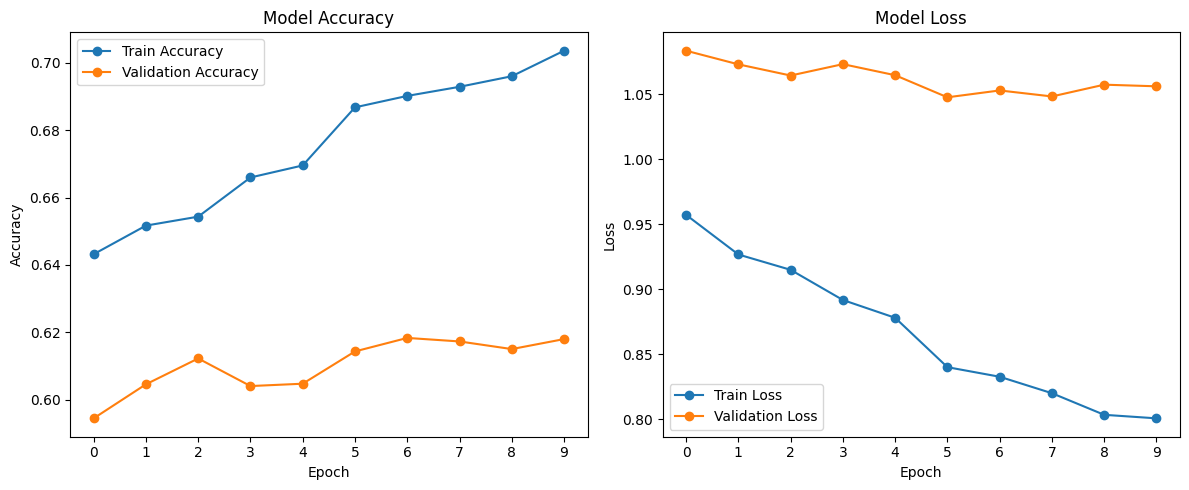

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FER2013/ResNet50_FER2013_phase3.keras


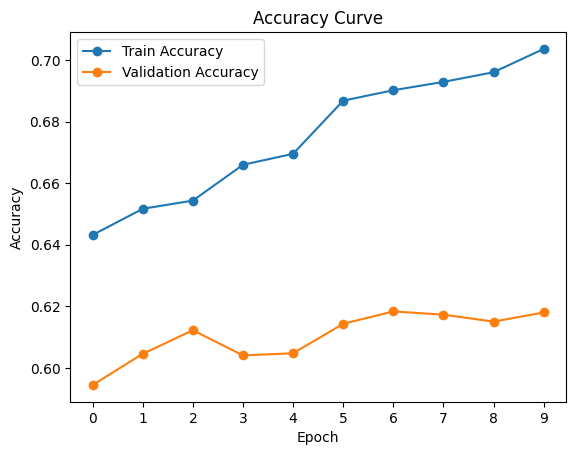

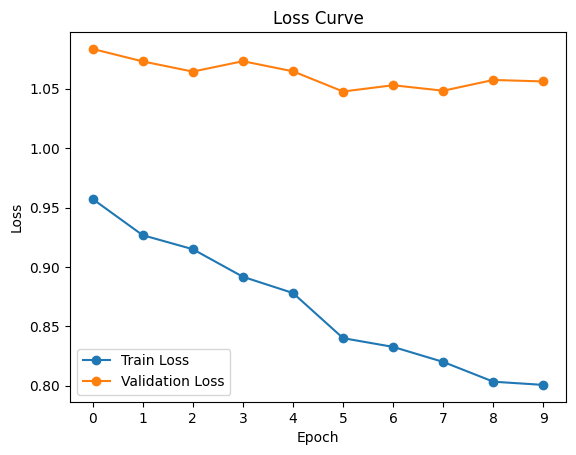

In [ ]:
# phase 3
lr = 5e-6
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_FER2013_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:81]:  #  81 | conv4_block1_1_conv
    layer.trainable = False
for layer in model.layers[81:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_FER2013_" + phase + ".keras")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 457s 594ms/step - accuracy: 0.6861 - loss: 0.8449 - val_accuracy: 0.6126 - val_loss: 1.0629 - learning_rate: 1.0000e-05
Epoch 2/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 410s 571ms/step - accuracy: 0.6842 - loss: 0.8384 - val_accuracy: 0.6168 - val_loss: 1.0498 - learning_rate: 1.0000e-05
Epoch 3/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 410s 570ms/step - accuracy: 0.7012 - loss: 0.8016 - val_accuracy: 0.6187 - val_loss: 1.0817 - learning_rate: 1.0000e-05
Epoch 4/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 404s 563ms/step - accuracy: 0.7154 - loss: 0.7680 - val_accuracy: 0.6217 - val_loss: 1.0489 - learning_rate: 1.0000e-05
Epoch 5/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 443s 563ms/step - accuracy: 0.7136 - loss: 0.7591 - val_accuracy: 0.6246 - val_loss: 1.0618 - learning_rate: 1.0000e-05


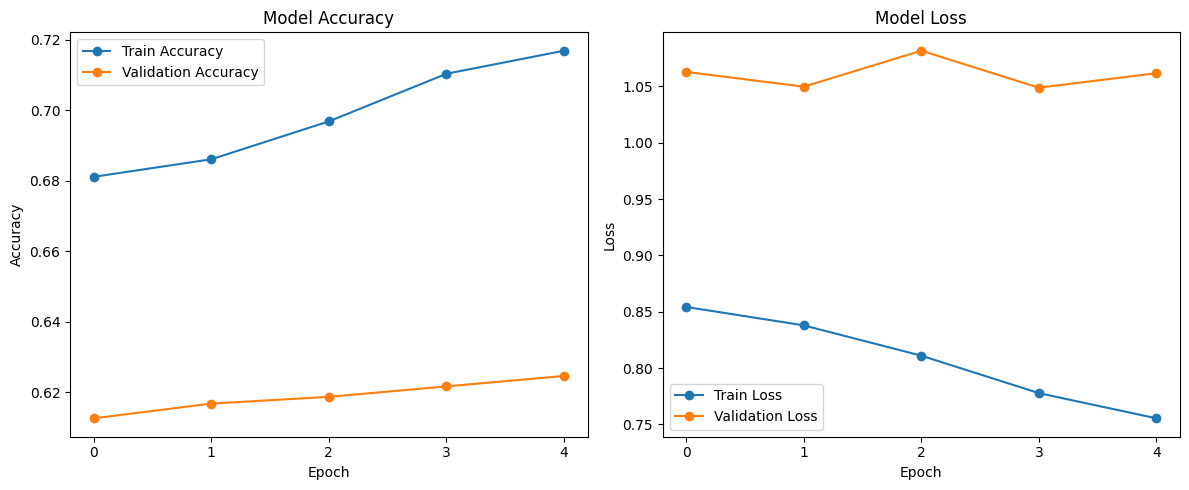

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/ResNet50/FER2013/ResNet50_FER2013_phase4.keras


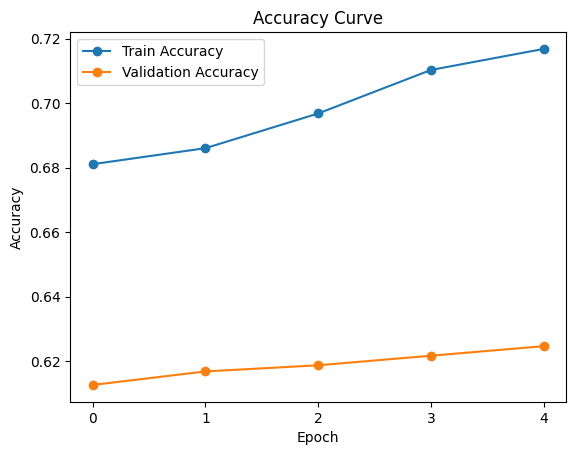

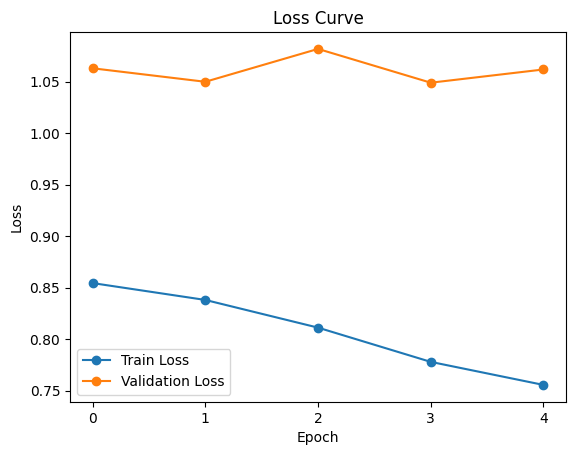

In [ ]:
# phase 4
lr = 1e-5
epochs = 5
batch_size = 32
phase = 'phase4'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)


# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/ResNet50_FER2013_phase3.keras", compile=False)

model.trainable = True
for layer in model.layers[:39]:  #  39 | conv3_block1_1_conv
    layer.trainable = False
for layer in model.layers[39:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "ResNet50_FER2013_" + phase + ".keras")

# 新增區段

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Trainable params:", np.sum([np.prod(v.shape) for v in base_model.trainable_weights]))

base_model.trainable = False
#base_model.trainable = False
for i, layer in enumerate(base_model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

Trainable params: 23534592
  0 | input_layer_2                            | trainable = False
  1 | conv1_pad                                | trainable = False
  2 | conv1_conv                               | trainable = False
  3 | conv1_bn                                 | trainable = False
  4 | conv1_relu                               | trainable = False
  5 | pool1_pad                                | trainable = False
  6 | pool1_pool                               | trainable = False
  7 | conv2_block1_1_conv                      | trainable = False
  8 | conv2_block1_1_bn                        | trainable = False
  9 | conv2_block1_1_relu                      | trainable = False
 10 | conv2_block1_2_conv                      | trainable = False
 11 | conv2_block1_2_bn                        | trainable = False
 12 | conv2_block1_2_relu                      | trainable = False
 13 | conv2_block1_0_conv                      | trainable = False
 14 | conv2_block1_3_conv          

In [ ]:
model = build_model_with_head(base_model, 7)
for i, layer in enumerate(model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

  0 | input_layer_2                            | trainable = False
  1 | conv1_pad                                | trainable = False
  2 | conv1_conv                               | trainable = False
  3 | conv1_bn                                 | trainable = False
  4 | conv1_relu                               | trainable = False
  5 | pool1_pad                                | trainable = False
  6 | pool1_pool                               | trainable = False
  7 | conv2_block1_1_conv                      | trainable = False
  8 | conv2_block1_1_bn                        | trainable = False
  9 | conv2_block1_1_relu                      | trainable = False
 10 | conv2_block1_2_conv                      | trainable = False
 11 | conv2_block1_2_bn                        | trainable = False
 12 | conv2_block1_2_relu                      | trainable = False
 13 | conv2_block1_0_conv                      | trainable = False
 14 | conv2_block1_3_conv                      | trainable = F

In [ ]:
for layer in base_model.layers[165:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True


for i, layer in enumerate(model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

  0 | input_layer_2                            | trainable = False
  1 | conv1_pad                                | trainable = False
  2 | conv1_conv                               | trainable = False
  3 | conv1_bn                                 | trainable = False
  4 | conv1_relu                               | trainable = False
  5 | pool1_pad                                | trainable = False
  6 | pool1_pool                               | trainable = False
  7 | conv2_block1_1_conv                      | trainable = False
  8 | conv2_block1_1_bn                        | trainable = False
  9 | conv2_block1_1_relu                      | trainable = False
 10 | conv2_block1_2_conv                      | trainable = False
 11 | conv2_block1_2_bn                        | trainable = False
 12 | conv2_block1_2_relu                      | trainable = False
 13 | conv2_block1_0_conv                      | trainable = False
 14 | conv2_block1_3_conv                      | trainable = F